In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import pipeline, XLMRobertaTokenizer, XLMRobertaForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report

# PreProcessing

In [33]:
label2id = {'SAD': 0, 'HAPPY': 1, 'HATE': 2, 'SURPRISE': 3, 'ANGRY': 4, 'FEAR': 5, 'OTHER': 6}
id2label = {0: 'SAD', 1: 'HAPPY', 2: 'HATE', 3: 'SURPRISE', 4: 'ANGRY', 5: 'FEAR', 6: 'OTHER'}

In [34]:
train_path = '/content/train.tsv'

train_df = pd.read_csv(train_path, sep='\t', header=None)
train_df.columns = ['text', 'label']

train_df

,text,label
0,خیلی کوچیک هستن و سایزشون بدرد نمیخوره میخوام ...,SAD
1,از صدای پرنده دم دمای صبح متنفرم متنفرم متنفرم,HATE
2,"""کیفیتش خیلی خوبه با شک خریدم ولی واقعا راضیم...",SAD
3,چون همش با دوربین ثبت شده ، ایا میشه اعتراض زد...,OTHER
4,اين وضع ب طرز خنده داري گريه داره ...,SAD
...,...,...
6120,مرحوم پیش بینی آبکی زیاد میکرد مرحوم عجب آ...,SURPRISE
6121,کلا عین اعتقادات و توئیت زدناتون ... !! در ق...,ANGRY
6122,خب وقتی میگی کسی بیاد مارو بگیره یارو ترس میکن...,FEAR
6123,همون هارو مگه آهنگ جدیدای خواننده‌های دهه ...,SURPRISE


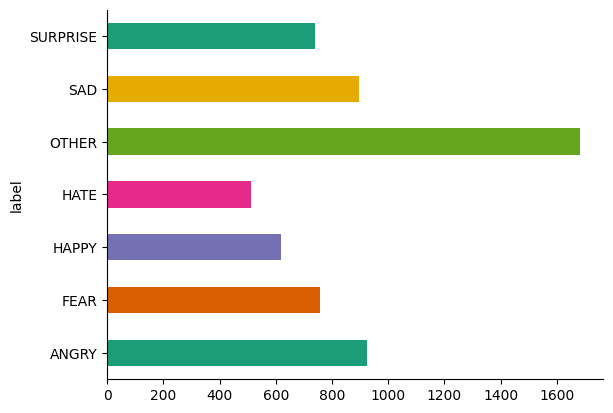

In [35]:
from matplotlib import pyplot as plt
import seaborn as sns
train_df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [36]:
train_df['label'] = train_df['label'].map(label2id)
train_df

,text,label
0,خیلی کوچیک هستن و سایزشون بدرد نمیخوره میخوام ...,0
1,از صدای پرنده دم دمای صبح متنفرم متنفرم متنفرم,2
2,"""کیفیتش خیلی خوبه با شک خریدم ولی واقعا راضیم...",0
3,چون همش با دوربین ثبت شده ، ایا میشه اعتراض زد...,6
4,اين وضع ب طرز خنده داري گريه داره ...,0
...,...,...
6120,مرحوم پیش بینی آبکی زیاد میکرد مرحوم عجب آ...,3
6121,کلا عین اعتقادات و توئیت زدناتون ... !! در ق...,4
6122,خب وقتی میگی کسی بیاد مارو بگیره یارو ترس میکن...,5
6123,همون هارو مگه آهنگ جدیدای خواننده‌های دهه ...,3


In [59]:
test_path = '/content/test.tsv'

test_df = pd.read_csv(test_path, sep='\t', header=None)
test_df.columns = ['text', 'label']

test_df

,text,label
0,اين شايد اولين عزاى عمومى واقعى است كه ياد دار...,SAD
1,دیشب بعد از ارسال تویت مربوط به آثار باستانی ت...,HAPPY
2,کدوم شعبه پول نداده، بگو الان برات آمار دقیق ...,OTHER
3,امروز وسط یه بحث با بابا مامانم گفتم آدم باید ...,HAPPY
4,امشب گفت نامزدی دوستش که ادم روشنفکری است بهم ...,SAD
...,...,...
1146,یعنی این آهنگ مرغ سحر جوری ساخته شده و روی این...,HAPPY
1147,درود بر همه ایرانیان شریف که در این سرما در تظ...,HAPPY
1148,امروز تولدم است،عید است ولی شاد نیستم،عید و تو...,SAD
1149,لعنت به اونی که دلتنگ نگهت میداره...,SAD


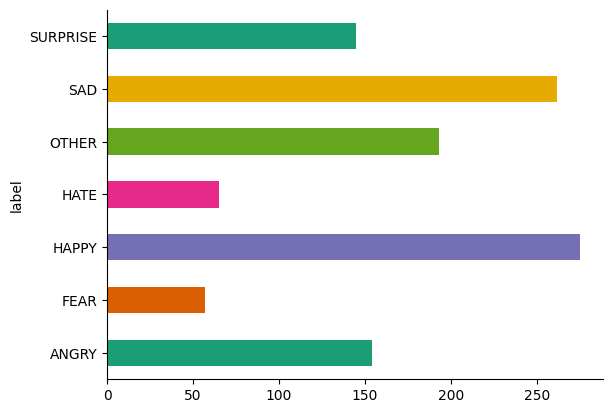

In [60]:
from matplotlib import pyplot as plt
import seaborn as sns
test_df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [61]:
test_df['label'] = test_df['label'].map(label2id)
test_df

,text,label
0,اين شايد اولين عزاى عمومى واقعى است كه ياد دار...,0
1,دیشب بعد از ارسال تویت مربوط به آثار باستانی ت...,1
2,کدوم شعبه پول نداده، بگو الان برات آمار دقیق ...,6
3,امروز وسط یه بحث با بابا مامانم گفتم آدم باید ...,1
4,امشب گفت نامزدی دوستش که ادم روشنفکری است بهم ...,0
...,...,...
1146,یعنی این آهنگ مرغ سحر جوری ساخته شده و روی این...,1
1147,درود بر همه ایرانیان شریف که در این سرما در تظ...,1
1148,امروز تولدم است،عید است ولی شاد نیستم،عید و تو...,0
1149,لعنت به اونی که دلتنگ نگهت میداره...,0


In [62]:
print(f"train data size is {len(train_df)}")
print(f"test data size is {len(test_df)}")

train data size is 6125
test data size is 1151


In [10]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Train models

In [11]:
def train_model(model_name, train_df, test_df, id2label, zero_shot, number_of_epochs = 3, learning_rates = [1e-5, 1e-5, 1e-5]):

  # Initialize tokenizer and model
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 7)

  # Move the model to GPU
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)

  # Create datasets and dataloaders
  train_dataset = CustomDataset(train_df['text'].values, train_df['label'].values, tokenizer)
  test_dataset = CustomDataset(test_df['text'].values, test_df['label'].values, tokenizer)

  train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
  test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

  if not zero_shot:
    # Training loop (optional if you have labeled data)
    # Skip this part if you're doing zero-shot learning
    # Train the model
    for epoch in range(number_of_epochs):
        # Define optimizer and loss function
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rates[epoch])
        criterion = torch.nn.CrossEntropyLoss()
        model.train()
        for i, batch in enumerate(train_dataloader):
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          labels = batch['label'].to(device)

          optimizer.zero_grad()
          outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
          logits = outputs.logits
          loss = outputs.loss
          if i % 100 == 0:
            print(f"epoch {epoch}, batch number {i}, loss {loss}")
          loss.backward()
          optimizer.step()

  # Evaluation
  model.eval()
  all_preds = []
  all_labels = []

  for batch in test_dataloader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)

      with torch.no_grad():
          outputs = model(input_ids, attention_mask=attention_mask)

      logits = outputs.logits
      preds = torch.argmax(logits, dim=1).cpu().numpy()

      all_preds.extend(preds)
      all_labels.extend(labels.cpu().numpy())

  # Convert numerical labels back to text labels
  predicted_labels = [id2label[label] for label in all_preds]
  true_labels = [id2label[label] for label in all_labels]

  # Print classification report
  print(classification_report(true_labels, predicted_labels))
  return model, tokenizer


## zero-shot on XLM-RoBERTa-base



In [ ]:
train_model('xlm-roberta-base', train_df, test_df, id2label, zero_shot = True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/loc

              precision    recall  f1-score   support

       ANGRY       0.00      0.00      0.00       154
        FEAR       0.00      0.00      0.00        57
       HAPPY       0.00      0.00      0.00       275
        HATE       0.00      0.00      0.00        65
       OTHER       0.00      0.00      0.00       193
         SAD       0.23      1.00      0.37       262
    SURPRISE       0.00      0.00      0.00       145

    accuracy                           0.23      1151
   macro avg       0.03      0.14      0.05      1151
weighted avg       0.05      0.23      0.08      1151



XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768,

## zero-shot on XLM-RoBERTa-large

In [ ]:
train_model('xlm-roberta-large', train_df, test_df, id2label, zero_shot = True)

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lo

              precision    recall  f1-score   support

       ANGRY       0.00      0.00      0.00       154
        FEAR       0.00      0.00      0.00        57
       HAPPY       0.00      0.00      0.00       275
        HATE       0.00      0.00      0.00        65
       OTHER       0.00      0.00      0.00       193
         SAD       0.00      0.00      0.00       262
    SURPRISE       0.13      1.00      0.22       145

    accuracy                           0.13      1151
   macro avg       0.02      0.14      0.03      1151
weighted avg       0.02      0.13      0.03      1151



XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=1024, out_fe

## fine_tune XLM-RoBERTa-base


In [ ]:
roberta_base_model = train_model('xlm-roberta-base', train_df, test_df, id2label, zero_shot = False)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0, batch number 0, loss 2.0383048057556152
epoch 0, batch number 100, loss 1.9170889854431152
epoch 0, batch number 200, loss 1.8232935667037964
epoch 0, batch number 300, loss 1.7571840286254883
epoch 0, batch number 400, loss 1.9930063486099243
epoch 0, batch number 500, loss 1.7982618808746338
epoch 0, batch number 600, loss 1.4305851459503174
epoch 0, batch number 700, loss 0.8048447370529175
epoch 1, batch number 0, loss 1.6205625534057617
epoch 1, batch number 100, loss 1.070280909538269
epoch 1, batch number 200, loss 1.5445753335952759
epoch 1, batch number 300, loss 1.4375882148742676
epoch 1, batch number 400, loss 1.3563101291656494
epoch 1, batch number 500, loss 1.4446581602096558
epoch 1, batch number 600, loss 0.9437900185585022
epoch 1, batch number 700, loss 0.8399819731712341
epoch 2, batch number 0, loss 1.4614536762237549
epoch 2, batch number 100, loss 0.31827017664909363
epoch 2, batch number 200, loss 1.0221256017684937
epoch 2, batch number 300, loss 0.313

In [ ]:
roberta_base_model.save_pretrained('RoBERTa-base-model')

In [ ]:
!huggingface-cli upload 'RoBERTa-base-model'

Consider using `hf_transfer` for faster uploads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
model.safetensors: 100% 1.11G/1.11G [00:28<00:00, 39.2MB/s]
https://huggingface.co/am-azadi/RoBERTa-base-model/tree/main/.


## fine-tune XLM-RoBERTa-large

In [ ]:
roberta_large_model, roberta_large_tokenizer = train_model('xlm-roberta-large', train_df, test_df, id2label, zero_shot = False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0, batch number 0, loss 2.214966297149658
epoch 0, batch number 100, loss 1.909036636352539
epoch 0, batch number 200, loss 2.1287782192230225
epoch 0, batch number 300, loss 1.809217095375061
epoch 0, batch number 400, loss 1.2906194925308228
epoch 0, batch number 500, loss 0.4139288067817688
epoch 0, batch number 600, loss 1.0441155433654785
epoch 0, batch number 700, loss 1.5030441284179688
epoch 1, batch number 0, loss 1.1459347009658813
epoch 1, batch number 100, loss 1.0209804773330688
epoch 1, batch number 200, loss 1.307298183441162
epoch 1, batch number 300, loss 0.5476933121681213
epoch 1, batch number 400, loss 1.2103716135025024
epoch 1, batch number 500, loss 1.0238006114959717
epoch 1, batch number 600, loss 1.155189871788025
epoch 1, batch number 700, loss 1.1625521183013916
epoch 2, batch number 0, loss 0.90763258934021
epoch 2, batch number 100, loss 0.2662128806114197
epoch 2, batch number 200, loss 0.33797508478164673
epoch 2, batch number 300, loss 0.162159323

In [ ]:
roberta_large_model.save_pretrained('RoBERTa-large-model')
roberta_large_tokenizer.save_pretrained('RoBERTa-large-model')

In [ ]:
!huggingface-cli upload 'RoBERTa-large-model'

Consider using `hf_transfer` for faster uploads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
model.safetensors: 100% 2.24G/2.24G [00:52<00:00, 43.0MB/s]
https://huggingface.co/am-azadi/RoBERTa-large-model/tree/main/.


## zero-shot on ParsBERT

In [12]:
train_model('HooshvareLab/bert-base-parsbert-uncased', train_df, test_df, id2label, zero_shot = True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


              precision    recall  f1-score   support

       ANGRY       0.00      0.00      0.00       154
        FEAR       0.04      0.02      0.02        57
       HAPPY       0.27      0.18      0.22       275
        HATE       0.08      0.03      0.04        65
       OTHER       0.00      0.00      0.00       193
         SAD       0.41      0.03      0.05       262
    SURPRISE       0.13      0.77      0.22       145

    accuracy                           0.15      1151
   macro avg       0.13      0.15      0.08      1151
weighted avg       0.18      0.15      0.09      1151



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

## fine-tune ParsBERT

In [13]:
ParseBERT_model = train_model('HooshvareLab/bert-base-parsbert-uncased', train_df, test_df, id2label, zero_shot = False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 0, batch number 0, loss 2.054973840713501
epoch 0, batch number 100, loss 1.651625394821167
epoch 0, batch number 200, loss 1.5445711612701416
epoch 0, batch number 300, loss 0.99512779712677
epoch 0, batch number 400, loss 0.5240366458892822
epoch 0, batch number 500, loss 1.5574946403503418
epoch 0, batch number 600, loss 0.9037876725196838
epoch 0, batch number 700, loss 0.9686088562011719
epoch 1, batch number 0, loss 0.8155895471572876
epoch 1, batch number 100, loss 0.8345014452934265
epoch 1, batch number 200, loss 0.552848219871521
epoch 1, batch number 300, loss 0.4438103139400482
epoch 1, batch number 400, loss 0.39836519956588745
epoch 1, batch number 500, loss 0.8211452960968018
epoch 1, batch number 600, loss 0.4126322567462921
epoch 1, batch number 700, loss 1.070664644241333
epoch 2, batch number 0, loss 0.12699703872203827
epoch 2, batch number 100, loss 0.3623749911785126
epoch 2, batch number 200, loss 0.21773481369018555
epoch 2, batch number 300, loss 0.736205

In [14]:
ParseBERT_model.save_pretrained('parsBERT-model')

In [17]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [18]:
!huggingface-cli upload 'parsBERT-model'

Consider using `hf_transfer` for faster uploads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
model.safetensors: 100% 651M/651M [00:19<00:00, 32.7MB/s]
https://huggingface.co/am-azadi/parsBERT-model/tree/main/.


## Improving the best model

In [13]:
new_best_model, new_best_tokenizer = train_model('am-azadi/RoBERTa-large-model', train_df, test_df, id2label, zero_shot = False, number_of_epochs = 2, learning_rates = [1e-7, 1e-9])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


epoch 0, batch number 0, loss 0.4572300314903259
epoch 0, batch number 100, loss 0.19898968935012817
epoch 0, batch number 200, loss 0.1234063059091568
epoch 0, batch number 300, loss 0.3033754527568817
epoch 0, batch number 400, loss 0.15691256523132324
epoch 0, batch number 500, loss 0.42633000016212463
epoch 0, batch number 600, loss 0.14592182636260986
epoch 0, batch number 700, loss 0.23040004074573517
epoch 1, batch number 0, loss 1.832901954650879
epoch 1, batch number 100, loss 0.07735228538513184
epoch 1, batch number 200, loss 0.20808371901512146
epoch 1, batch number 300, loss 0.7219831943511963
epoch 1, batch number 400, loss 0.5468224883079529
epoch 1, batch number 500, loss 0.2834640145301819
epoch 1, batch number 600, loss 0.31887176632881165
epoch 1, batch number 700, loss 0.47271037101745605
              precision    recall  f1-score   support

       ANGRY       0.69      0.66      0.68       154
        FEAR       0.72      0.82      0.77        57
       HAPPY     

In [19]:
new_best_model.save_pretrained('best-model')
new_best_tokenizer.save_pretrained('best-model')

In [23]:
!huggingface-cli upload 'best-model'

Consider using `hf_transfer` for faster uploads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
sentencepiece.bpe.model:   0% 0.00/5.07M [00:00<?, ?B/s]
tokenizer.json:   0% 0.00/17.1M [00:00<?, ?B/s]

sentencepiece.bpe.model:   0% 16.4k/5.07M [00:00<00:40, 126kB/s]
tokenizer.json:   0% 16.4k/17.1M [00:00<02:17, 124kB/s]
tokenizer.json:  34% 5.80M/17.1M [00:00<00:00, 30.1MB/s]
sentencepiece.bpe.model: 100% 5.07M/5.07M [00:00<00:00, 11.1MB/s]


tokenizer.json: 100% 17.1M/17.1M [00:00<00:00, 22.4MB/s]


Upload 2 LFS files: 100% 2/2 [00:00<00:00,  2.02it/s]
https://huggingface.co/am-azadi/best-model/tree/main/.


# Evaluation

In [ ]:
def preprocess(data_path):
  label2id = {'SAD': 0, 'HAPPY': 1, 'HATE': 2, 'SURPRISE': 3, 'ANGRY': 4, 'FEAR': 5, 'OTHER': 6}
  df = pd.read_csv(data_path, sep='\t', header=None)
  df.columns = ['text', 'label']
  df['label'] = train_df['label'].map(label2id)
  return df

In [12]:
def predict_and_evaluate(df):

  tokenizer = AutoTokenizer.from_pretrained('am-azadi/best-model')
  model = AutoModelForSequenceClassification.from_pretrained('am-azadi/best-model', num_labels = 7)
  id2label = {0: 'SAD', 1: 'HAPPY', 2: 'HATE', 3: 'SURPRISE', 4: 'ANGRY', 5: 'FEAR', 6: 'OTHER'}

  # Move the model to GPU
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)

  # Create datasets and dataloaders
  dataset = CustomDataset(df['text'].values, df['label'].values, tokenizer)

  dataloader = DataLoader(dataset, batch_size=8, shuffle=False)

  # Evaluation
  model.eval()
  all_preds = []
  all_labels = []

  for batch in dataloader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)

      with torch.no_grad():
          outputs = model(input_ids, attention_mask=attention_mask)

      logits = outputs.logits
      preds = torch.argmax(logits, dim=1).cpu().numpy()

      all_preds.extend(preds)
      all_labels.extend(labels.cpu().numpy())

  # Convert numerical labels back to text labels
  predicted_labels = [id2label[label] for label in all_preds]
  true_labels = [id2label[label] for label in all_labels]

  # Print classification report
  print(classification_report(true_labels, predicted_labels))
  return predicted_labels

## some mismatched Sentences

In [13]:
predicted_labels = predict_and_evaluate(test_df)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


              precision    recall  f1-score   support

       ANGRY       0.69      0.66      0.68       154
        FEAR       0.72      0.82      0.77        57
       HAPPY       0.90      0.74      0.81       275
        HATE       0.80      0.60      0.68        65
       OTHER       0.60      0.80      0.69       193
         SAD       0.77      0.87      0.82       262
    SURPRISE       0.83      0.61      0.71       145

    accuracy                           0.75      1151
   macro avg       0.76      0.73      0.74      1151
weighted avg       0.77      0.75      0.75      1151



In [63]:
def get_mislabeled_sentences(df, predicted_labels):
  filtered_df = df
  filtered_df['predicted_label'] = predicted_labels
  filtered_df['label'] = filtered_df['label'].map(id2label)
  filtered_df = filtered_df[filtered_df['label'] != predicted_labels]
  return filtered_df

In [64]:
filtered_df = get_mislabeled_sentences(test_df, predicted_labels)
print(len(filtered_df))

286


In [65]:
filtered_df

,text,label,predicted_label
1,دیشب بعد از ارسال تویت مربوط به آثار باستانی ت...,HAPPY,SAD
4,امشب گفت نامزدی دوستش که ادم روشنفکری است بهم ...,SAD,FEAR
7,دلمه خوردن تو خونهی مادربزرگ با خاله ها و خنده...,HAPPY,SAD
8,فن مترو خراب بود. ملت داشتن غر میزدن. آقای میا...,SURPRISE,SAD
15,دیدم حمیدرضا عارف در مصاحبه با انصاف نیوز گله ...,HATE,ANGRY
...,...,...,...
1115,سیل بند کارش جلو گیری از خسارت سیله وقتی میشکن...,ANGRY,SAD
1127,همین که مجبور شد شاش رو دست فرار کنه خودش پایا...,HAPPY,OTHER
1130,شما خودتو ناراحت نكن دوشنبه سانديس ميدن بدو ت...,OTHER,SAD
1137,ایشان امیر یعقوبی (امیر خلخالی) فرزند حاکم و ق...,HATE,ANGRY
